# Description

This is the preprocessing pipeline.

The result is a single object that contains all the transformed images and its metadata (labels and boxes).

The pipeline consists of several stages. In saving memory purposes the object keeps only the last state of the images. The metadata requires a few amount of memory so it is no problem to keep it for all the stages. However, an image can be displayed with either intermediate stage of its transforming: it is computed from the raw for each time. This is no problem to "wait" while a single image is being computed once again, but we don't need to keep all of these (generally unnecessary) intermediate stages in the memory.

All the data is handled with its indices: no sample is represented in the memory twice (unless some relatively small temporary buffers etc.).

The data is splitted into train, validation and test samples.

First, each image is transformed from colourful (3 layers) to grayscale (1 layer as the mean of 3). It decreases required memory and computational time. Also, it helps to generalize: cats and dogs can be of any color and the picture can be color-distorted (or grayscale initially) as well. So it is better to be independent of colours.

Then, an image is padded with the border replicate method to achieve a form of square. This unifies the initially different forms.

Finally, all the images are resized to the unify size. The size of 256x256 is used. Also, was tried 192x192 and 128x128.

Optionally, the mean computed on the train sample can be subtracted from all the images. It is recommended to do this, but somehow the models show better performance without mean subtracting.

The augmentation is applied only to the train sample. The augmentation increases the data amount for 5 times: 4 modified images on each initial. These are the flips and 90 degree rotates: an example is represented in the end of the paper.

# Imports and environment

In [1]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import os
import pickle

from IPython.display import display as disp

# Preprocessing

## Classes and functions

In [2]:
class image_objects():
    """
    Image loading and preprocessing.
    """
    
    def __init__(self, path, filenames,):
        """
        Initialization.
        Loads the metadata from a local disk.
        path : files directory
        filenames : array of the arrays of the two items (jpg and txt) for each image
        """
        self.path = path
        self.filenames = filenames
        self.augmentation_is_done = False
        
        self.meta_raw = []
        for i in np.arange(self.filenames.shape[0]):
            with open(f'{self.path}{self.filenames[i, 1]}', 'r') as f:
                string = f.read()
            self.meta_raw.append(np.array(string.split(' '), dtype='int'))
        
        self.meta_raw = np.array(self.meta_raw)
    
    
    def split_indices(self, valid_frac, test_frac,):
        """
        Splits the indices to the train, validation and test samples.
        """
        index = np.arange(self.meta_raw.shape[0])
        labels = self.meta_raw[:, 0].copy()
        classes = np.unique(self.meta_raw[:, 0])

        index_by_class = []

        for i in np.arange(classes.shape[0]):
            index_by_class.append(index[labels == classes[i]])
            np.random.shuffle(index_by_class[i])

            bounds = np.array(
                [
                    index_by_class[i].shape[0] * (1 - (valid_frac + test_frac)),
                    index_by_class[i].shape[0] * (1 - test_frac),
                ],
                dtype = 'int'
            )

            index_by_class[i] = [
                index_by_class[i][:bounds[0]],
                index_by_class[i][bounds[0]:bounds[1]],
                index_by_class[i][bounds[1]:],
            ]

        self.index_tr_basic = np.array([], dtype='int')
        self.index_va = np.array([], dtype='int')
        self.index_te = np.array([], dtype='int')

        for i in np.arange(classes.shape[0]):
            self.index_tr_basic = np.append(self.index_tr_basic, index_by_class[i][0])
            self.index_va = np.append(self.index_va, index_by_class[i][1])
            self.index_te = np.append(self.index_te, index_by_class[i][2])

        np.random.shuffle(self.index_tr_basic)
        np.random.shuffle(self.index_va)
        np.random.shuffle(self.index_te)

        print(self.index_tr_basic.shape)
        print(self.index_va.shape)
        print(self.index_te.shape)


    def transform(self, size=256, subtract_mean=False,):
        """
        Transforms the images from raw to input-ready format.
        size : size of the final square image
        """
        self.size = size
        self.meta_bw = self.meta_raw.copy()
        self.meta_padded = self.meta_raw.copy()
        self.meta_resized = self.meta_padded.copy()
        self.pads = np.zeros((self.filenames.shape[0], 4), dtype='int')
        self.size_raw = []
        self.imgs = []
        
        for i in np.arange(self.filenames.shape[0]):
            img = np.array(Image.open(f'{self.path}{self.filenames[i, 0]}'))
            if img.ndim == 2:
                img = np.expand_dims(img, 2)
            self.size_raw.append(img.shape[:2])
        
            # Black and white
            img = np.mean(img, axis=2, dtype='int')
            
            # Padding
            self.pads[i, 0] = (np.max(img.shape[:2]) - img.shape[0]) // 2                     # top
            self.pads[i, 1] = (np.max(img.shape[:2]) - img.shape[0]) // 2 + img.shape[0] % 2  # bottom
            self.pads[i, 2] = (np.max(img.shape[:2]) - img.shape[1]) // 2                     # left
            self.pads[i, 3] = (np.max(img.shape[:2]) - img.shape[1]) // 2 + img.shape[1] % 2  # right
            
            img = cv2.copyMakeBorder(img, *self.pads[i], cv2.BORDER_REPLICATE)
            self.meta_padded[i, 1] += self.pads[i, 2]
            self.meta_padded[i, 2] += self.pads[i, 0]
            self.meta_padded[i, 3] += self.pads[i, 3]
            self.meta_padded[i, 4] += self.pads[i, 1]
            
            # Resizing
            img = cv2.resize(img.astype('float64'), (self.size, self.size), interpolation=cv2.INTER_CUBIC)
            self.meta_resized[i] = self.meta_padded[i]
            self.meta_resized[i, 1:5] = np.round(self.meta_resized[i, 1:5] * (self.size / np.max(self.size_raw[i])), 0).astype('int')
            
            # Adding an image to the list
            self.imgs.append(np.array(img, dtype='uint8'))
        
        # Forming the array of images
        self.imgs = np.array(self.imgs, dtype='uint8')
        
        # Subtracting the mean
        if subtract_mean:
            mean = np.round(np.mean(self.imgs[self.index_tr_basic]), 0).astype('uint8')
            self.imgs -= mean

        self.size_raw = np.array(self.size_raw)
        
        self.print_imgs_array_details()
    
    
    def show(self, i=None, mode='resized', roi=True,):
        """
        Displays the image.
        mode : "raw", "bw", "padded", "resized"
        roi : bool
        """
        # Choosing the item
        i = i if i != None else np.random.randint(0, self.filenames.shape[0])
        print(i)

        # Loading the raw image if necessary
        if mode != 'mask':
            img_raw = np.array(Image.open(f'{self.path}{self.filenames[i, 0]}'))
        
        # Computing the image
        if mode == 'raw':
            img = img_raw
            ax_img = plt.imshow(img)
            meta = self.meta_raw[i]
        elif mode == 'bw':
            img = np.mean(img_raw, axis=2, dtype='int')
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            meta = self.meta_bw[i]
        elif mode == 'padded':
            img = cv2.copyMakeBorder(np.mean(img_raw, axis=2, dtype='int'), *self.pads[i], cv2.BORDER_REPLICATE)
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            meta = self.meta_padded[i]
        if mode == 'resized':
            img = cv2.resize(
                cv2.copyMakeBorder(np.mean(img_raw, axis=2, dtype='int'), *self.pads[i], cv2.BORDER_REPLICATE).astype('float64'), 
                (self.size, self.size),
                interpolation=cv2.INTER_CUBIC
            )
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            try:
                meta = self.meta_resized[i]
            except:
                meta = self.meta_augment[i]
        if mode == 'mask':
            img = self.imgs[i, 1]
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            try:
                meta = self.meta_resized[i]
            except:
                meta = self.meta_augment[i]
        
        # Plotting the image
        disp(meta)
        ax = []
        ax.append(ax_img)
        if roi:
            ax.append(plt.vlines((meta[1], meta[3],), meta[2], meta[4], colors='red'))
            ax.append(plt.hlines((meta[2], meta[4],), meta[1], meta[3], colors='red'))
        plt.show(ax)
    
    
    def augmentation(self,):
        """
        Implementation of the augmentation.
        """
        if self.augmentation_is_done is not True:
            self.imgs = np.append(self.imgs, np.flip(self.imgs[self.index_tr_basic], axis=2), axis=0)
            self.imgs = np.append(self.imgs, np.transpose(self.imgs[self.index_tr_basic], axes=(0, 2, 1)), axis=0)
            self.imgs = np.append(self.imgs, np.flip(np.transpose(self.imgs[self.index_tr_basic], axes=(0, 2, 1)), axis=2), axis=0)
            self.imgs = np.append(self.imgs, np.flip(self.imgs[self.index_tr_basic], axis=1), axis=0)

            meta_1 = self.meta_resized[self.index_tr_basic].copy()
            meta_2 = self.meta_resized[self.index_tr_basic].copy()
            meta_3 = self.meta_resized[self.index_tr_basic].copy()
            meta_4 = self.meta_resized[self.index_tr_basic].copy()

            meta_1[:, 1] = self.size - self.meta_resized[self.index_tr_basic][:, 3]
            meta_1[:, 3] = self.size - self.meta_resized[self.index_tr_basic][:, 1]

            meta_2[:, 1] = meta_1[:, 2]
            meta_2[:, 2] = self.size - meta_1[:, 3]
            meta_2[:, 3] = meta_1[:, 4]
            meta_2[:, 4] = self.size - meta_1[:, 1]

            meta_3[:, 1] = self.size - meta_2[:, 3]
            meta_3[:, 2] = meta_2[:, 2]
            meta_3[:, 3] = self.size - meta_2[:, 1]
            meta_3[:, 4] = meta_2[:, 4]

            meta_4[:, 2] = self.size - self.meta_resized[self.index_tr_basic][:, 4]
            meta_4[:, 4] = self.size - self.meta_resized[self.index_tr_basic][:, 2]

            self.meta_augment = self.meta_resized.copy()
            self.meta_augment = np.append(self.meta_augment, meta_1, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_2, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_3, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_4, axis=0)
        
        self.index_tr = self.index_tr_basic.copy()
        self.index_tr = np.append(self.index_tr, np.arange(self.filenames.shape[0], self.imgs.shape[0]))
        
        self.meta_ready = self.meta_augment.copy().astype('float64')
        self.meta_ready[:, 0][self.meta_ready[:, 0] == 2] = 0
        self.meta_ready[:, 1:] = self.meta_ready[:, 1:] * 1. / self.size
        
        self.augmentation_is_done = True
        self.print_imgs_array_details()
        

    def print_imgs_array_details(self,):
        """
        Displays imgs array shape, memory usage and dtype.
        """
        print(self.imgs.shape)
        print(images.imgs.nbytes // 1024**2, 'Mb')
        print(self.imgs.dtype)
    
    
    def unsqueeze_imgs(self,):
        """
        Inserts additional dimention in the second position (dim 1).
        
        For example:
        Shape: (1000, 192, 192) ---> (1000, 1, 192, 192)
        """
        self.imgs = self.imgs.reshape(self.imgs.shape[0], 1, self.imgs.shape[1], self.imgs.shape[2])
        self.print_imgs_array_details()
    
    
    def create_roi_masks(self,):
        """
        Creates the binary layer where pixels of ROI are ones and others are zeros.
        USING THIS FOR TRAINING IS A LEAK!!!
        """
        self.imgs = self.imgs.reshape(self.imgs.shape[0], 1, self.imgs.shape[1], self.imgs.shape[2])
        self.imgs = np.concatenate((self.imgs, np.full(self.imgs.shape, 255, dtype='uint8')), axis=1)
        
        for i in np.arange(self.imgs.shape[0]):
            self.imgs[
                i,
                1,
                self.meta_augment[i, 2] : self.meta_augment[i, 4],
                self.meta_augment[i, 1] : self.meta_augment[i, 3],
            ] = 0
        
        self.print_imgs_array_details()
    
    
    def augmentation_show(self, i=None, mask=False,):
        """
        Displays the set of images after augmentation.
        """
        i = i if i != None else np.random.randint(0, self.index_tr_basic.shape[0])
        print(i)
        print(self.index_tr_basic[i])
        
        AUGS = 5
        fig, ax = plt.subplots(1, AUGS, figsize=(20, 5))
        
        for aug in np.arange(AUGS):
            if aug == 0:
                j = self.index_tr_basic[i]
            else:
                j = self.filenames.shape[0] + i + (aug - 1) * self.index_tr_basic.shape[0]
            disp(self.meta_augment[j])
            if self.imgs.ndim == 3:
                ax[aug].imshow(self.imgs[j], cmap='gray',)
            elif self.imgs.ndim == 4:
                layer = 1 if mask else 0
                ax[aug].imshow(self.imgs[j, layer], cmap='gray',)
            ax[aug].vlines((self.meta_augment[j, 1], self.meta_augment[j, 3],), self.meta_augment[j, 2], self.meta_augment[j, 4], colors='red')
            ax[aug].hlines((self.meta_augment[j, 2], self.meta_augment[j, 4],), self.meta_augment[j, 1], self.meta_augment[j, 3], colors='red')

        plt.show(fig)

## Applying

### Initialization

In [4]:
path = './data/cats_dogs_dataset/'
filenames = (np.sort(os.listdir(path)))
filenames = filenames.reshape(filenames.shape[0] // 2, 2)

disp(filenames[:5])

array([['Abyssinian_1.jpg', 'Abyssinian_1.txt'],
       ['Abyssinian_10.jpg', 'Abyssinian_10.txt'],
       ['Abyssinian_100.jpg', 'Abyssinian_100.txt'],
       ['Abyssinian_101.jpg', 'Abyssinian_101.txt'],
       ['Abyssinian_102.jpg', 'Abyssinian_102.txt']], dtype='<U34')

In [5]:
images = image_objects(path, filenames)

### Computing the arrays

In [6]:
images.split_indices(valid_frac=0.08, test_frac=0.12,)

(2707,)
(271,)
(407,)


In [7]:
images.transform(size=256)

(3385, 256, 256)
211 Mb
uint8


In [8]:
images.augmentation()

(14213, 256, 256)
888 Mb
uint8


In [9]:
# images.create_roi_masks()

In [10]:
images.unsqueeze_imgs()

(14213, 1, 256, 256)
888 Mb
uint8


### Checking up the results

3274


array([  2, 113,  69, 177, 127])

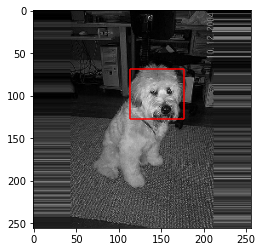

In [11]:
images.show()

2357
2012


array([  2,  27,  51, 211, 195])

array([  2,  45,  51, 229, 195])

array([  2,  51,  27, 195, 211])

array([  2,  61,  27, 205, 211])

array([  2,  27,  61, 211, 205])

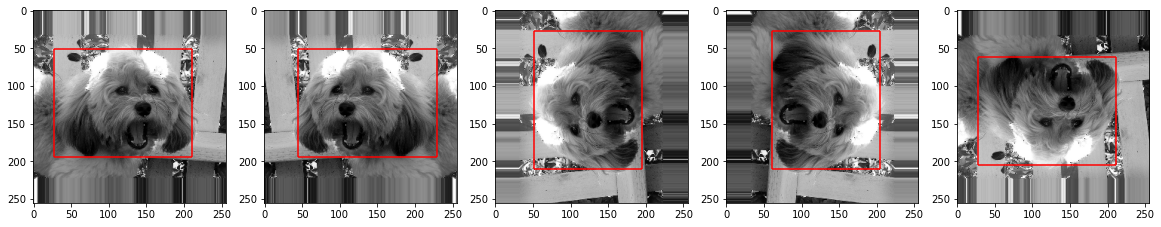

In [12]:
images.augmentation_show()

In [13]:
# images.augmentation_show(mask=True)

In [14]:
disp(images.index_tr[:10])
disp(images.index_tr[-10:])
disp(images.index_va[:20])
disp(images.index_te[:20])

array([ 492, 2008, 3383, 1771, 2844, 2100,  177,  534, 3318, 1031])

array([14203, 14204, 14205, 14206, 14207, 14208, 14209, 14210, 14211,
       14212])

array([2742, 1842, 1831, 1536, 2652, 2916, 1520, 3249, 1604, 1288, 2157,
        609, 2682,   98,  867, 1698, 3361,  635, 1147,  290])

array([3283, 2047, 2749,  214,  972,  442, 1707, 2977,  622, 2377, 2055,
       1269, 2539, 1119, 1681, 1662, 3347,  849, 1101, 2500])

In [15]:
disp(images.meta_ready[:10])

array([[1.        , 0.5546875 , 0.28515625, 0.70703125, 0.4296875 ],
       [1.        , 0.26953125, 0.2109375 , 0.703125  , 0.58203125],
       [1.        , 0.40625   , 0.140625  , 0.77734375, 0.53515625],
       [1.        , 0.12109375, 0.23046875, 0.70703125, 0.67578125],
       [1.        , 0.046875  , 0.08984375, 0.6484375 , 0.67578125],
       [1.        , 0.48046875, 0.28515625, 0.72265625, 0.54296875],
       [1.        , 0.47265625, 0.32421875, 0.74609375, 0.578125  ],
       [1.        , 0.5625    , 0.26953125, 0.84765625, 0.53125   ],
       [1.        , 0.1875    , 0.203125  , 0.55078125, 0.59375   ],
       [1.        , 0.1015625 , 0.125     , 0.671875  , 0.703125  ]])

## Saving the results

In [16]:
with open('./data/images256.pkl', 'wb') as f:
    pickle.dump(images, f)